# Imports

In [87]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve as prc


#from sklearn.model_selection import 
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
import itertools



In [88]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Read and Prepare Data 

In [130]:
# Read data
df=pd.read_csv('Data-Classification.txt')


# Create Train and Test Splits
X=df.iloc[:,1:] 
y=df.iloc[:,0] # Separate input and output
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42) 

In [90]:
y.unique()

array(['A', 'C', 'B'], dtype=object)

# Benchmark Models and Performance

## Algorithms 

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [92]:
benchmark_algorithms ={
    'LR' : LogisticRegression(),
    'RF' : RandomForestClassifier(),
    'KNN': KNeighborsClassifier()
 }

## Performance metrics

In [93]:
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import roc_auc_score


def mine_roc_auc(y_true, y_pred, average='micro'):
    '''
    Wrapper for AUC type measures (auroc and auprc),
    because they demand input in form of dummy variables
    '''
    y_true_dummy = pd.get_dummies(y_true)
    y_pred_dummy = pd.get_dummies(y_pred)
    return (roc_auc_score(y_true_dummy, y_pred_dummy, average=average))

# Scoring dict to be used in all evaluations
scoring = {
           'au_prc_macro': make_scorer(mine_roc_auc, average='macro'),
           'au_prc_micro': make_scorer(mine_roc_auc, average='macro'),
           'f1_macro': 'f1_macro',
           'f1_micro': 'f1_micro',
           'precision_macro': 'precision_macro',
           'precision_micro': 'precision_micro',
           'accuracy': 'accuracy',
          }

###!!!!!! Micro Macro Explanation https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/16001
### !!! plotting cross val cv

In [94]:
from sklearn.model_selection import cross_validate
#from sklearn.metrics import recall_score

models_dict = {}
scores_dict = {}

for model_name, model in benchmark_algorithms.items():
    
    scores = cross_validate(model, X_train, y_train, scoring=scoring,
                            cv=5, return_train_score=False)
    scores_aggregated= { measure: '%.3f' % round(np.average(values),3)
                                  #{'avg': '%.3f' % round(np.average(values),3)}\
                                   #'std': '%.2f' % round(np.std(values),2)} \
                                    for measure, values in scores.items()}
    scores_dict.update({model_name:scores_aggregated})
    
    fitted_model = model.fit(X_train, y_train)
    models_dict.update({model_name:fitted_model})
    
    



In [95]:
pd.DataFrame(scores_dict)

,KNN,LR,RF
fit_time,0.002,0.086,0.022
score_time,0.033,0.008,0.014
test_accuracy,0.394,0.948,0.903
test_au_prc_macro,0.546,0.961,0.927
test_au_prc_micro,0.546,0.961,0.927
test_f1_macro,0.388,0.948,0.904
test_f1_micro,0.394,0.948,0.903
test_precision_macro,0.397,0.948,0.908
test_precision_micro,0.394,0.948,0.903


In [96]:
from sklearn.metrics import confusion_matrix
confusions={}
for name, model in models_dict.items():
    y_predicted = model.predict(X_test)
    confusions.update({name: confusion_matrix(y_predicted, y_test)})

In [97]:
confusions['LR']

array([[109,   1,   5],
       [  0, 108,   1],
       [  4,   0, 102]])

In [136]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = title+' (Normalized)'

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [99]:
%matplotlib inline

In [100]:
cls=np.unique(y_train)
cls

array(['A', 'B', 'C'], dtype=object)

In [101]:
models_dict

{'KNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=5, p=2,
            weights='uniform'),
 'LR': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'RF': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False)}

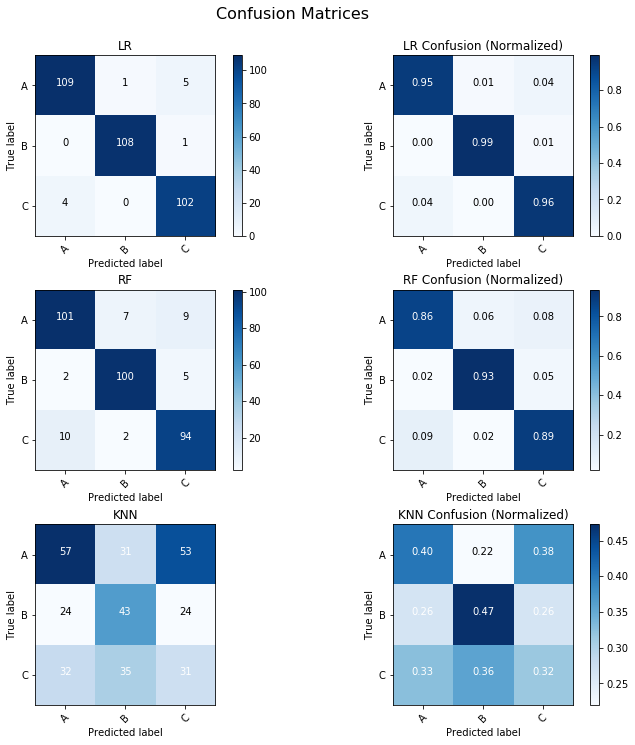

In [102]:
arrangement=[(321,322), (323, 324), (325, 326)]
i=0
fig=plt.figure(1, figsize=(10,10))
fig.suptitle('Confusion Matrices', fontsize=16, y=1.03)
for name, conf in confusions.items(): 
    ax1=plt.subplot(arrangement[i][0])
    plot_confusion_matrix(cm =conf, classes = cls, normalize=False, title = name)

    plt.subplot(arrangement[i][1])
    plot_confusion_matrix(cm =conf, classes = cls, normalize=True, title = name + ' Confusion')
    fig.subplots_adjust(wspace=0.05, hspace=0.3)
    i+=1


In [71]:
fig.savefig('Confusions_Benchmark')

In [72]:
scores_dict

{'KNN': {'fit_time': {'avg': '0.003', 'std': '0.00'},
  'score_time': {'avg': '0.041', 'std': '0.00'},
  'test_accuracy': {'avg': '0.394', 'std': '0.04'},
  'test_au_prc_macro': {'avg': '0.546', 'std': '0.03'},
  'test_au_prc_micro': {'avg': '0.546', 'std': '0.03'},
  'test_f1_macro': {'avg': '0.388', 'std': '0.05'},
  'test_f1_micro': {'avg': '0.394', 'std': '0.04'},
  'test_precision_macro': {'avg': '0.397', 'std': '0.04'},
  'test_precision_micro': {'avg': '0.394', 'std': '0.04'},
  'train_accuracy': {'avg': '0.616', 'std': '0.01'},
  'train_au_prc_macro': {'avg': '0.712', 'std': '0.01'},
  'train_au_prc_micro': {'avg': '0.712', 'std': '0.01'},
  'train_f1_macro': {'avg': '0.612', 'std': '0.01'},
  'train_f1_micro': {'avg': '0.616', 'std': '0.01'},
  'train_precision_macro': {'avg': '0.628', 'std': '0.01'},
  'train_precision_micro': {'avg': '0.616', 'std': '0.01'}},
 'LR': {'fit_time': {'avg': '0.127', 'std': '0.05'},
  'score_time': {'avg': '0.014', 'std': '0.00'},
  'test_accurac

# Feature Selection and Parameter Optimization

Since benchmark model (Logistic regression) gave good results in terms of different validation measure (both on training and test data), further analyses will be focused on finding:
- More interpretable solutions
- More robust solutions (in terms of generalization)

For this purpose, hyper-parameters of models will be optimized as well as feature selection

## Imports 

In [103]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Lasso

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import MinMaxScaler

## Pipeline

In [104]:
# Check if it can be done with simple Pipeline()
pipe = Pipeline([
    ('normalize', MinMaxScaler(feature_range=(1,2))),
    ('reduce_dim', PCA()),
    ('classify', RidgeClassifier())
     ])

## Define Classifiers and parameter ranges

In [105]:
'''
Heuristics that define algorithm hyper parameter ranges based on number of samples and number of features
'''

def n_features_range(n_samples=100, m_features=3, m_n_ratio=1):
    '''
    Used for definition of algorithm parameters based on available number of features
     and samples, after feature selection.
     
    It is used for definition of grid search params through a pipeline
     
    :param n_samples: number of samples in the dataframe/matrix
    :param m_features: number of features after feature selection
    :param m_n_ratio: maximal number of features relative to number of samples
    
    :return: range of numbers of features used for param optimization in algorithms 
    '''

    max_features = int(round(n_samples / m_n_ratio))
    if m_features < max_features:
        max_features = m_features

    if m_features == 1:
        min_features = 1
    else:
        min_features = 2

    step_size = int(round(np.log2(max_features)))

    param_range = [a for a in range(min_features, max_features, step_size)]

    if param_range[-1] < max_features:
        param_range.append(max_features)

    return param_range

def nn_size(m_features):
    half = int(np.ceil((m_features + 1) / 2))
    quarter = int(np.ceil((m_features + 1) / 4))
    size = [(quarter,), (half,)]
    return (size)

In [106]:
def rf_param_dict(name='classify', estimators=[RandomForestClassifier()], n_samples=1000, m_features=[15]):
    dict={
        name: estimators,
        name + '__' + 'n_estimators': range(20, 101, 20),
        name + '__' + 'max_features': n_features_range(n_samples, m_features),
        name + '__' + 'min_samples_leaf': np.arange(0.01, 0.03, 0.05),
        name + '__' + 'max_depth': range(2, 11, 2)
    }
    return (dict)

def ann_param_dict(name='classify', estimators=[MLPClassifier()], n_samples=100, m_features=15):
    dict={
        name: estimators,
        name + '__' + 'learning_rate': ['constant'],
        name + '__' + 'momentum': [0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9],
        name + '__' + 'max_iter': [100000],
        name + '__' + 'hidden_layer_sizes': nn_size(m_features)
    }
    return (dict)

def knn_param_dict(name='classify', estimators=[KNeighborsClassifier()], n_samples=1000, m_features=15): # Check this if needed
    dict={
        name: estimators,
        name + '__' + 'n_neighbors': [3, 5, 7],    
    }
    return (dict)

def logistic_param_dict(name='classify', estimators=[LogisticRegression()], n_samples=1000, m_features=15): # Check this if needed
    dict={
        name: estimators,
        name + '__' + 'penalty': ['l1', 'l2'],
        name + '__' + 'C': [0.01, 0.03, 0.1, 0.5, 0.8, 1],
        name + '__' + 'max_iter': [10000],
        name + '__' + 'solver': ['saga']
        # check for multinomial
    }
    return (dict)



## Define Feature Selectors and Parameter ranges

In [107]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import NMF

In [108]:
def create_params_pca_nmf(name='reduce_dim', reducers=[PCA(), NMF()], n_samples=100, m_features=[5, 10, 15, 20, 25, 30], funcs=[]):
    params=[]

    for func in funcs.values():
        for m in m_features:
            dict = {
                name: reducers,
                name+'__'+'n_components':[m]
            }
            dict.update(func(m_features=m))

            params.append(dict.copy())
    return (params)

def create_params_select_from_model(name='reduce_dim', reducers=[SelectKBest('f_classif'), SelectKBest('mutual_info_classif')], n_samples=100, m_features=[5, 10, 15, 20, 25, 30], funcs=[]):
    params=[]
    for func in funcs.values(): 
        for m in m_features:
            dict = {
                name: reducers,
                name+'__'+'k':[m]
            }
            dict.update(func(m_features=m))

            params.append(dict.copy())
    return (params)

## Create Param Grid for Hyper Parameter and Feature Search

In [109]:
# set algorithms param grics
algorithms= {'logistic':logistic_param_dict, 'ann': ann_param_dict, 'knn' : knn_param_dict, 'rf': rf_param_dict}

# take number of samples and feature number range 
n_samples = X_train.shape[0]
m_features = [5, 10, 15, 20, 25, 30]

In [110]:
pars1 = create_params_pca_nmf(name='reduce_dim', reducers=[PCA(), NMF()], n_samples=n_samples,\
                              m_features=m_features, funcs=algorithms)
pars2 = create_params_select_from_model(name='reduce_dim', reducers=[SelectKBest(score_func=f_classif),\
                SelectKBest(score_func=mutual_info_classif)], n_samples=n_samples, m_features=m_features, funcs=algorithms)
pars = pars1 + pars2 # Concatenate lists with param grids

### !!!! one more round of experimtnts with added params

In [111]:
search=GridSearchCV(estimator = pipe, param_grid = pars, scoring=scoring, refit='au_prc_macro', cv=5, n_jobs=4,\
                    return_train_score=False).fit(X_train, y_train)
#!!Git set and work https://github.com/codepath/ios_guides/wiki/Using-Git-with-Terminal 

/home/vucko83/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vucko83/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vucko83/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vucko83/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vucko83/anaconda

In [149]:
CVResults=search.cv_results_
log_df=pd.DataFrame(CVResults).sort_values('mean_test_au_prc_macro', ascending=False) # log2Pandas
log_df.to_csv('results.csv') # Sort and store for analyses

In [151]:
log_df

,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_au_prc_macro,mean_test_au_prc_micro,mean_test_f1_macro,mean_test_f1_micro,mean_test_precision_macro,mean_test_precision_micro,param_classify,...,split4_test_precision_micro,std_fit_time,std_score_time,std_test_accuracy,std_test_au_prc_macro,std_test_au_prc_micro,std_test_f1_macro,std_test_f1_micro,std_test_precision_macro,std_test_precision_micro
2223,0.861164,0.010110,0.965672,0.974223,0.974223,0.965851,0.965672,0.966300,0.965672,"MLPClassifier(activation='relu', alpha=0.0001,...",...,0.977444,0.131415,0.000295,0.013677,0.010281,0.010281,0.013619,0.013677,0.013373,0.013677
2189,0.843537,0.010098,0.965672,0.974216,0.974216,0.965957,0.965672,0.966940,0.965672,"MLPClassifier(activation='relu', alpha=0.0001,...",...,0.992481,0.057824,0.000305,0.016598,0.012542,0.012542,0.016538,0.016598,0.015859,0.016598
2184,0.717215,0.009692,0.964179,0.973146,0.973146,0.964431,0.964179,0.965142,0.964179,"MLPClassifier(activation='relu', alpha=0.0001,...",...,0.992481,0.086814,0.000302,0.022155,0.016688,0.016688,0.022023,0.022155,0.021266,0.022155
2188,0.743398,0.009974,0.964179,0.973108,0.973108,0.964422,0.964179,0.965055,0.964179,"MLPClassifier(activation='relu', alpha=0.0001,...",...,0.984962,0.076230,0.000301,0.017093,0.012867,0.012867,0.017003,0.017093,0.016603,0.017093
287,2.433668,0.069049,0.962687,0.972076,0.972076,0.962851,0.962687,0.963000,0.962687,"MLPClassifier(activation='relu', alpha=0.0001,...",...,0.992481,0.059641,0.034636,0.020951,0.015696,0.015696,0.020893,0.020951,0.020906,0.020951
2009,0.213264,0.009552,0.962687,0.972060,0.972060,0.962992,0.962687,0.963633,0.962687,"LogisticRegression(C=1.0, class_weight=None, d...",...,0.984962,0.012099,0.000186,0.019826,0.014972,0.014972,0.019705,0.019826,0.018855,0.019826
2191,0.870667,0.009836,0.962687,0.972044,0.972044,0.962968,0.962687,0.963889,0.962687,"MLPClassifier(activation='relu', alpha=0.0001,...",...,0.977444,0.286093,0.000258,0.013999,0.010633,0.010633,0.013947,0.013999,0.013099,0.013999
286,1.082746,0.018345,0.962687,0.972005,0.972005,0.962812,0.962687,0.963292,0.962687,"MLPClassifier(activation='relu', alpha=0.0001,...",...,0.992481,0.218875,0.011111,0.021439,0.016146,0.016146,0.021507,0.021439,0.021353,0.021439
2033,0.214744,0.009840,0.962687,0.972005,0.972005,0.962965,0.962687,0.963826,0.962687,"LogisticRegression(C=1.0, class_weight=None, d...",...,0.992481,0.002521,0.000528,0.024322,0.018327,0.018327,0.024145,0.024322,0.022969,0.024322
2012,0.059459,0.009751,0.962687,0.972002,0.972002,0.962953,0.962687,0.963656,0.962687,"LogisticRegression(C=1.0, class_weight=None, d...",...,0.984962,0.011937,0.000682,0.019826,0.014950,0.014950,0.019691,0.019826,0.018863,0.019826


In [132]:
y_pred=search.best_estimator_.predict(X_test)

In [137]:
cm = confusion_matrix(y_test, y_pred)

In [138]:
cls=np.unique(y_train)

In [225]:
a=log_df.iloc[5,:]['params']

In [226]:
pipa = pipe.set_params(**a)

In [227]:
y_pred=pipa.fit(X_train, y_train).predict(X_test)
cm = confusion_matrix(y_test, y_pred)


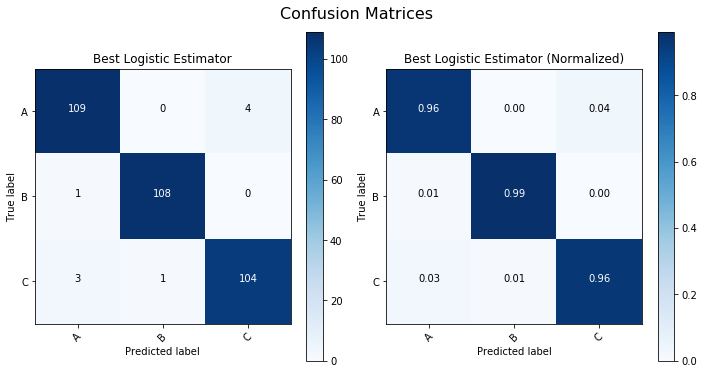

In [230]:


fig=plt.figure(1, figsize=(10,5))
fig.suptitle('Confusion Matrices', fontsize=16, y=1.03)
     
plt.subplot(121)
    
plot_confusion_matrix(cm =cm, classes = cls, normalize=False, title = 'Best Logistic Estimator')

plt.subplot(122)

plot_confusion_matrix(cm =cm, classes = cls, normalize=True, title = 'Best Logistic Estimator')

fig.subplots_adjust(wspace=0.1, hspace=0.3)
plt.savefig('ConfusionBestLR')
    

In [ ]:
plot_confusion_matrix(cm, cls)

## GridSearchCV log analyses

In [ ]:
pipe.set_params(**a).fit(X_train, y_train).predict(X_test)


In [718]:
search.cv_results_

{'mean_fit_time': array([ 0.0109551 ,  0.65677562,  0.0816834 ,  0.18826756,  0.24026718,
         0.16335015,  0.01153383,  0.27298131,  0.08154159,  0.36969075,
         0.00660005,  0.28755422,  0.02615285,  0.27820807,  0.08988695,
         0.29298196,  0.16692843,  0.17311163,  0.04517407,  0.22064333,
         0.00697832,  0.12571726,  0.040417  ,  0.22772217,  0.12976303,
         0.2157124 ,  0.07344737,  0.17564259,  0.07472625,  0.15537663,
         0.00716376,  0.1576632 ,  0.04687395,  0.13711381,  0.06568961,
         0.12925415,  0.17258077,  0.12471476,  0.13563619,  0.2234344 ,
         0.24317284,  0.26047168,  0.00657377,  0.21804714,  0.03444161,
         0.12741942,  0.10297322,  0.12763743,  0.01481915,  0.12234325,
         0.0062202 ,  0.12607584,  0.00753055,  0.13711395,  0.00710359,
         0.12383962,  0.05037103,  0.21970382,  0.00606103,  0.12771301,
         0.00937676,  0.13243017,  0.01241732,  0.13323517]),
 'mean_score_time': array([ 0.02240043,  0.01

In [313]:
pipe.set_params(**components)

Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [730]:
y_test = pipe.fit(X_train, y_train).predict(X_test)

In [ ]:
plot_confusion_matrix()

In [187]:
LogisticRegression(**a).fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [188]:
LogisticRegression(**a)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [145]:
dum_true = pd.get_dummies(y_test)

In [143]:
dum_pred = pd.get_dummies(lr_model.predict(X_test))

In [147]:
roc_auc_score(dum_true, dum_pred, average='micro', sample_weight=None)

0.97500000000000009

In [ ]:
#AUPRC in multilabel settings
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

In [ ]:
# Plot precision recall curves for multiclass
"""

from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()
"""

In [ ]:
# Reading from log
import ast
results=pd.read_csv('results.csv').head(10)
res=results.iloc[1]['params'].replace('\n','').strip()
res=" ".join(res.split())
ast.literal_eval(res)
res.named_steps
a={'classify': LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1, penalty='l2', random_state=None, solver='saga', tol=0.0001, verbose=0, warm_start=False), 'classify__C': 1, 'classify__max_iter': 10000, 'classify__penalty': 'l2', 'classify__solver': 'saga', 'reduce_dim': PCA(copy=True, iterated_power='auto', n_components=30, random_state=None, svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 30}

# Evaluation measures